# **The Navier-Stokes equations**
**Lovisa Enblad**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)


# **About the code**

In [37]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [38]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)

# **Method**

The Reynolds number, denoted as $Re$, is defined by the relationship $Re = \frac{UD}{\nu}$, where $U$ represents the flow velocity, $D$ is the cylinder's diameter serving as the characteristic length, and $\nu$ stands for the fluid's kinematic viscosity. By holding the velocity $U$ and the cylinder diameter $D$ constant, different Reynolds numbers can be achieved by adjusting $\nu$.

Initially, we modify $\nu$ to implicitly alter the Reynolds number to values of $Re = 1, 10, 100, 1000$. This exploration helps in determining the steady or transient nature of the flow, as well as in examining the drag and lift coefficients and the Strouhal number corresponding to each Reynolds number.

Subsequently, maintaining $Re$ at 100, we vary the mesh resolution starting from $h = \frac{1}{8}$ and progressing to $h = \frac{1}{16}$ and $h = \frac{1}{32}$. These alterations are made to observe their influence on the lift coefficient $C_L$, the drag coefficient $C_D$, and the Strouhal number $St$ using a progressively finer mesh.

**Define domain and mesh**

A rectangular domain is defined with a circular hole i position (1,1) with radius 0.2.

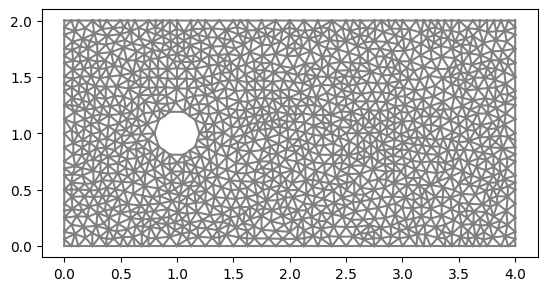

In [39]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

We define approximation spaces in the form of linear Lagrange polynomials. This is possible as we have a stabiliation.

In [40]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

The boudary conditions are defined with a horizonal inflow with velocity U = 1 and a slip condition on the upper and lower boundaries as well as a no-slip condition on the cylinder (circular hole).

In [41]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

The viscosity is changed to generate different Reynolds numbers, using the relationship: $Re = \frac{UD}{\nu}$.


In [42]:
# Set viscosity
nu = 4.0e-4 # Gives Re = 1000
# nu = 4.0e-3 # Gives Re = 100
# nu = 4.0e-2 # Gives Re = 10
# nu = 4.0e-1 # Gives Re = 1

**Define method parameters**

In [43]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [44]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

One can calculate the drag force by assigning ${\phi} = (1, 0)$, which aligns with the flow direction. Conversely, the lift force is determined by setting ${\phi} = (0, 1)$, orthogonal to the flow.


In [45]:
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [46]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3ff34d8f1b361e442e3c95eb987bf8a5b8d7723c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_290583, f_290586]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.092514 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7b9524f1cb973c49fa26ab3e6750d568194e1793

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_290583, f_290586, f_290592]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0779951 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1ff6d1dcea145d80232105f51f193fda2da87cb2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_290583, f_290586, f_290592, f_290596]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0465293 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC

Time t = 0.03285506167650246


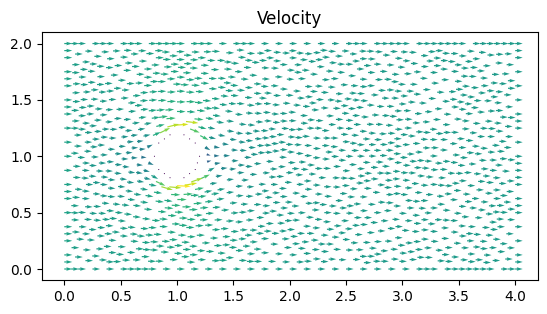

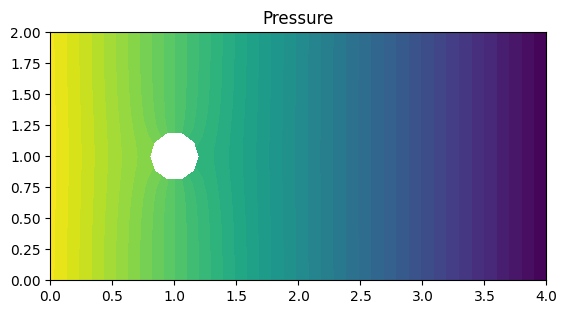

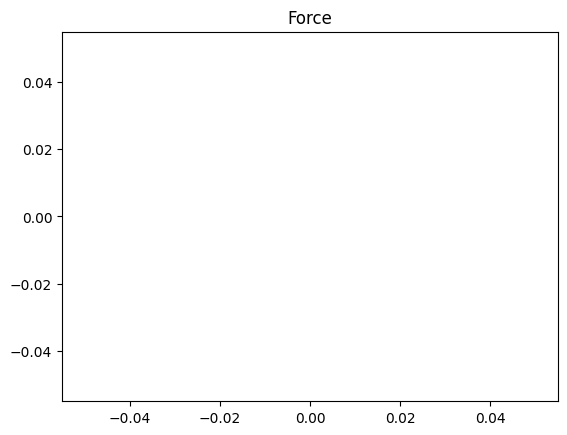

Time t = 3.022665674238231


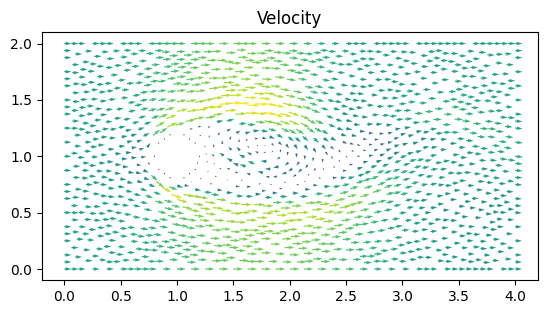

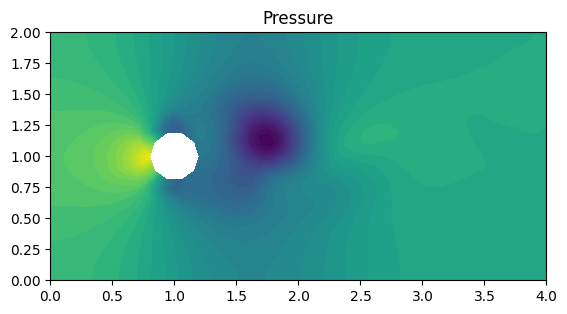

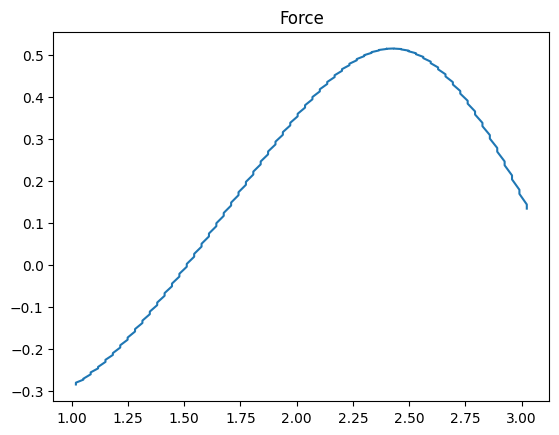

Time t = 6.012476286799972


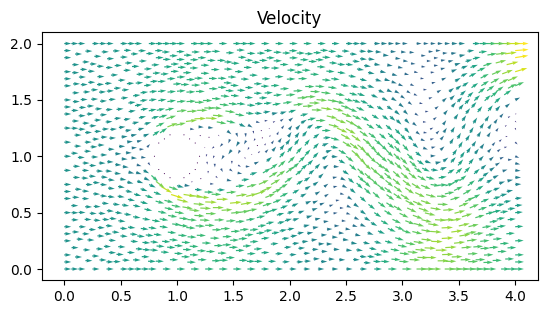

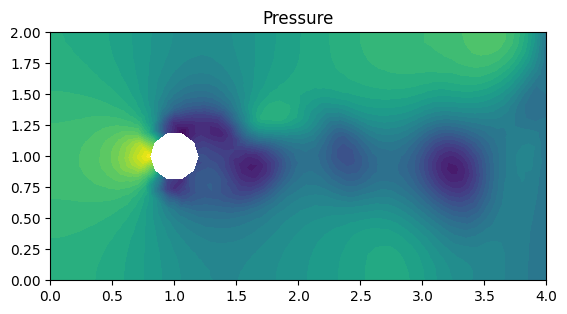

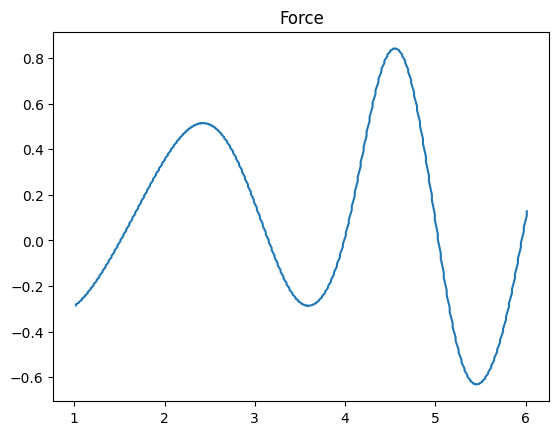

Time t = 9.002286899361685


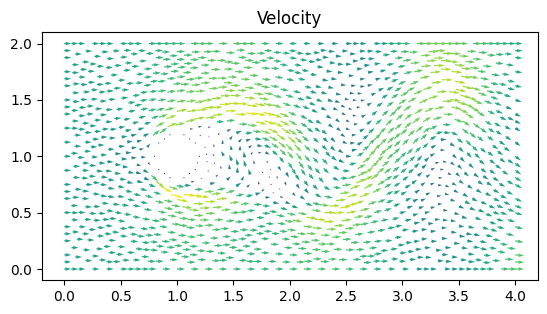

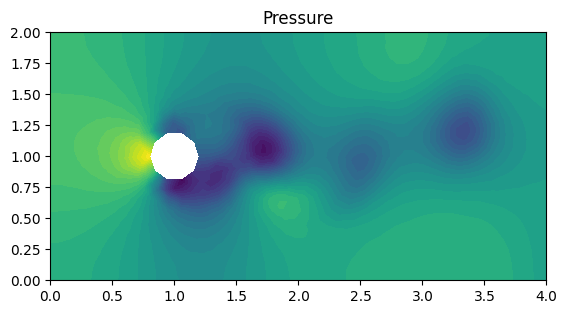

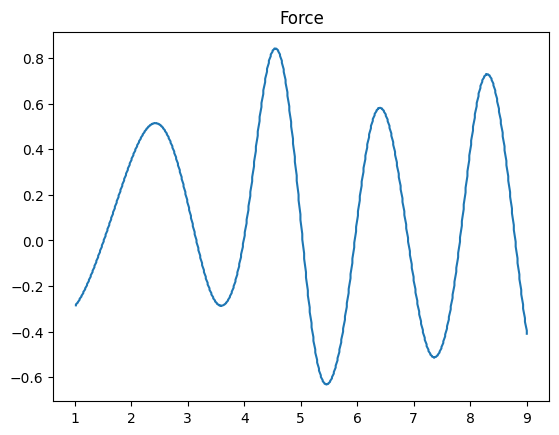

Time t = 12.024952573599847


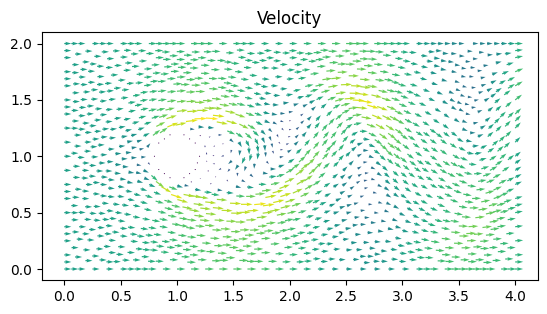

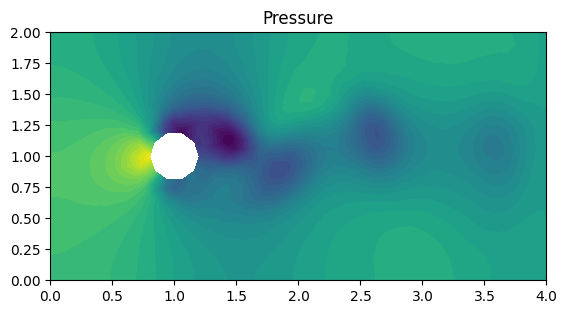

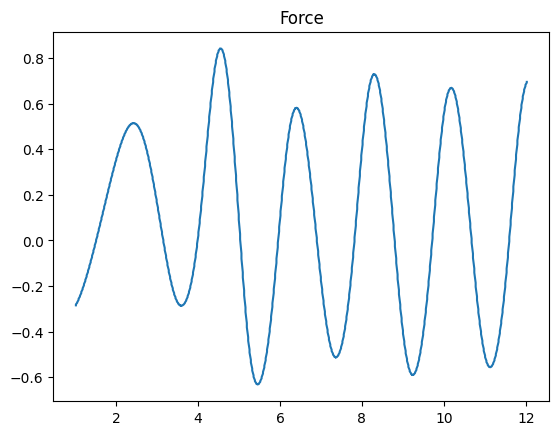

Time t = 15.014763186161508


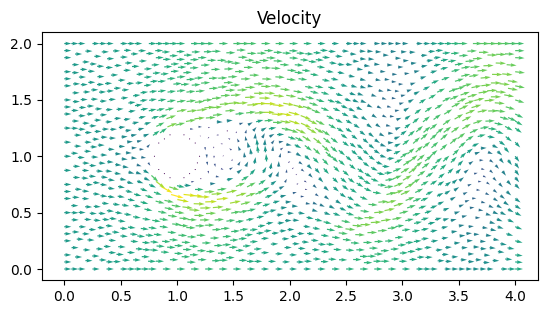

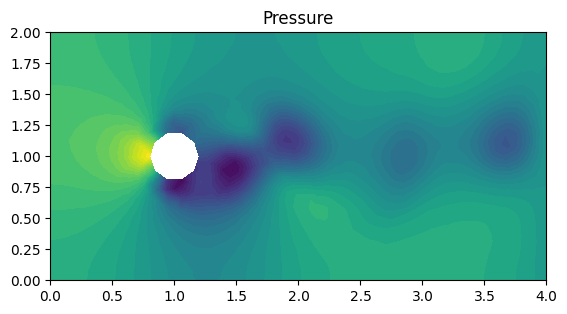

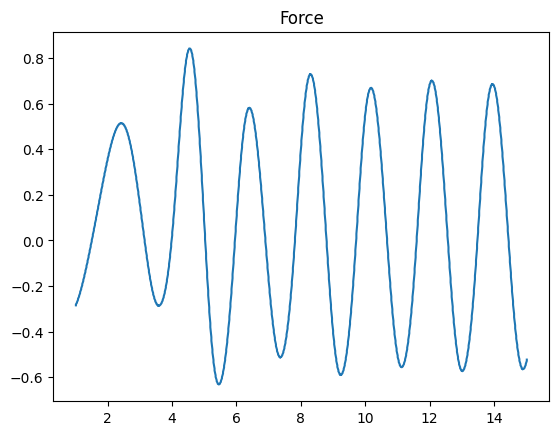

Time t = 18.00457379872328


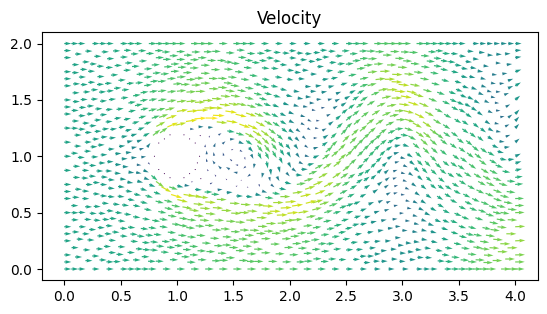

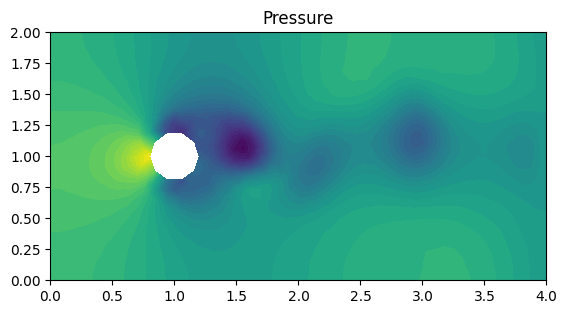

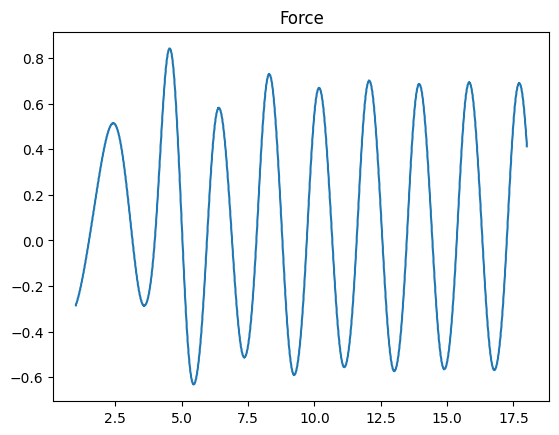

Time t = 21.027239472961604


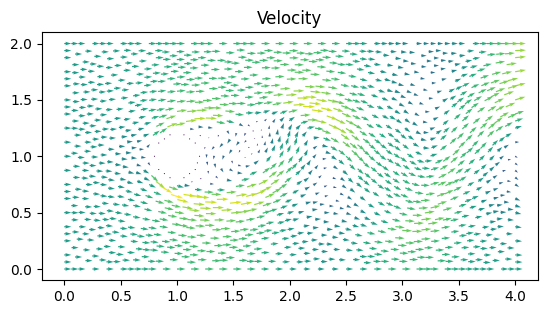

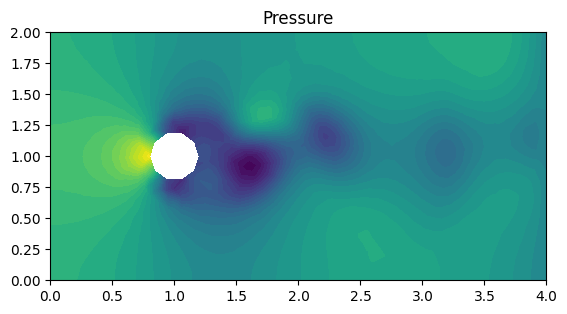

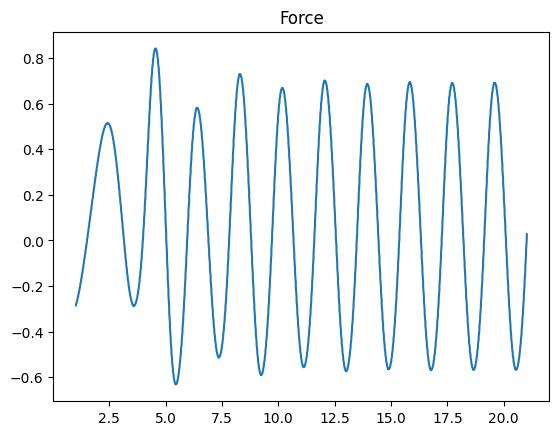

Time t = 24.017050085523426


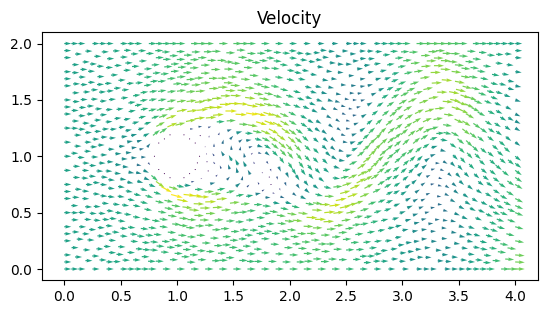

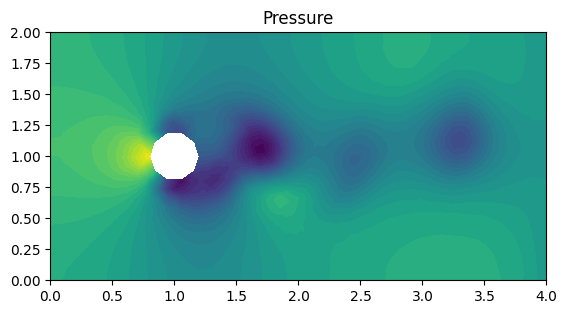

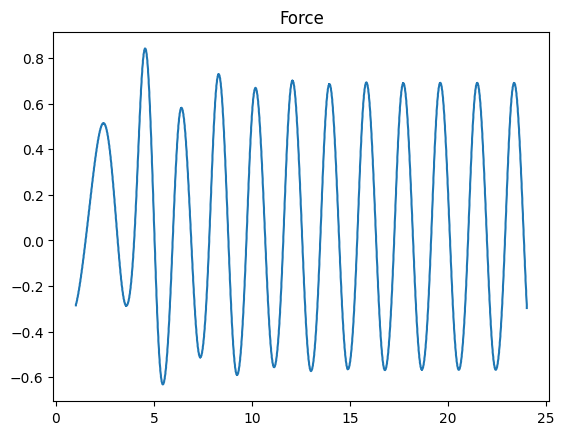

Time t = 27.006860698085248


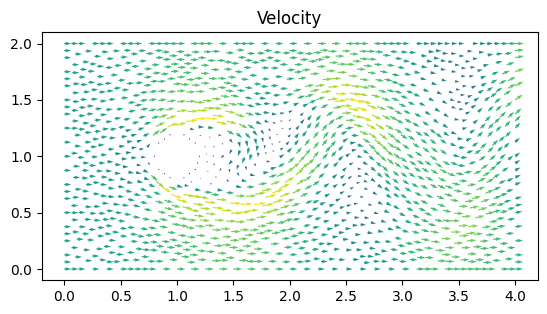

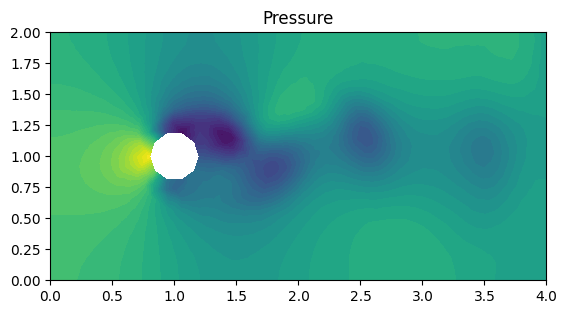

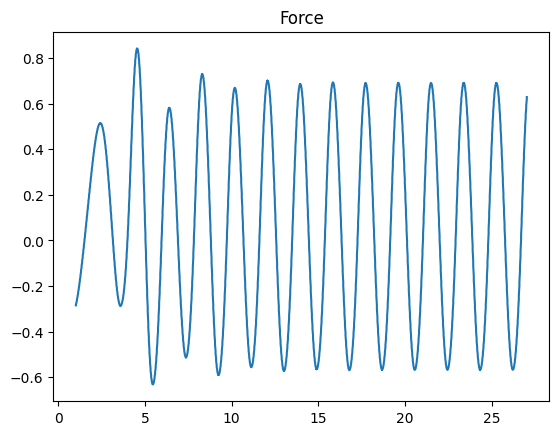

In [47]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

# !tar -czvf results-NS.tar.gz results-NS
# files.download('results-NS.tar.gz')



**Reynolds number**

In [48]:
U = 1  # Inflow velocity
D = rc * 2  # Diameter of the cylinder

# Calculating Reynolds number
Re = (U * D) / nu

print(f"Reynolds number: {Re}")

Reynolds number: 1000.0


**Figures**

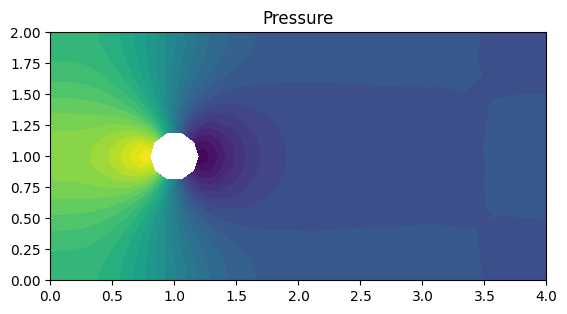

*Figure 1: Pressure solution for Re = 1 at final time*

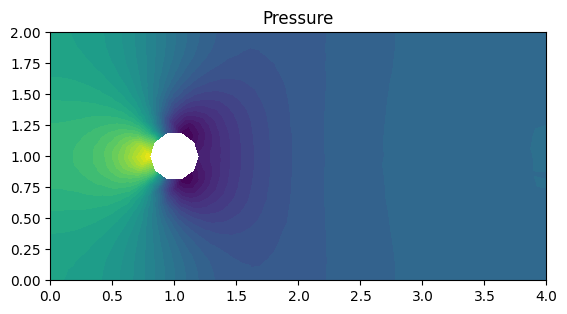

*Figure 2: Pressure solution for Re = 10 at final time*

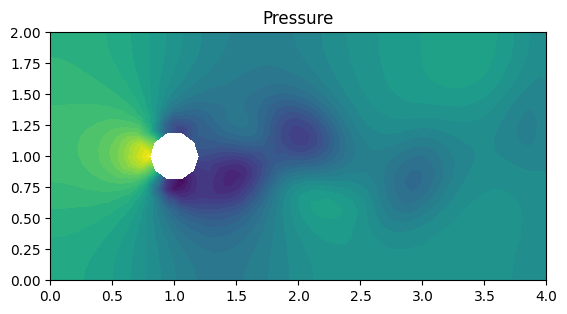

*Figure 3: Pressure solution for Re = 100 at final time*

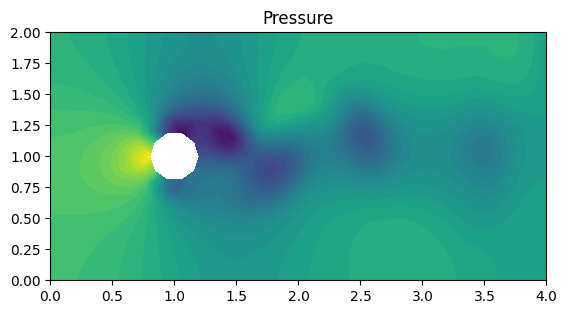

*Figure 4: Pressure solution for Re = 1000 for final time*

**Results for drag and lift coefficients and Strohal numbers for different Reynolds numbers with resolution 1/32**

**Re = 1**

$
c_D = 88.6
$

$
c_L = 0.2
$

$
St = 0
$

**Re = 10**

$
c_D = 18.0
$

$
c_L = 0.3
$

$
St = 0
$

**Re = 100**

$
c_D = 8.5
$

$
c_L = \pm 2
$

$
St = 0.18
$

**Re = 1000**

$
c_D = 7.6
$

$
c_L = \pm 3
$

$
St = 0.19
$


**Results for drag and lift coefficients and Strohal numbers for Re = 100 with different resolutions**

**Resolution = 1/8**

$
c_D = 15.0
$

$
c_L = -0.3
$

$
St = 0
$

**Resolution = 1/16**

$
c_D = 10.4
$

$
c_L = 0
$

$
St = 0.16
$

**Resolution = 1/32**

$
c_D = 8.5
$

$
c_L = \pm 2
$

$
St = 0.18
$

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution a von Karman vortex street developed as expected a von Karman vortex street developed as expected.


**Reynolds number (mandatory assignment)**

It was observed that for Re = 1 and Re = 10, the flow remained laminar and steady. The fluid exhibited smooth and consistent motion around the cylinder, manifesting symmetric flow patterns devoid of temporal fluctuations. As the Reynolds number escalated, transitional behavior emerged. Around Re = 100, the flow became unsteady, precipitating the formation of von Kármán vortex streets downstream of the cylinder. This phenomenon is characterized by the periodic shedding of alternating vortices from opposing sides of the cylinder. By Re = 1000, turbulence dominated the flow, rendering it unsteady. The flow pattern became increasingly chaotic, marked by irregular vortex shedding and a notable augmentation in mixing and wake fluctuations behind the cylinder.

**Drag and lift coefficients (mandatory assignment)**

The drag and lift coefficients were calculated using the formula described in the introduction:

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$.

The lift and drag forces were computed analytically by observing the force plot over time and taking an average (adjusting code for lift versus drag). The drag coefficients calculated were approximately 88.6 for Re = 1, 18.0 for Re = 10, 8.5 for Re = 100, and 7.6 for Re = 1000. At very low Reynolds numbers like Re = 1, the flow is predominantly laminar and highly viscous, leading to a high drag coefficient due to the dominance of viscous forces over inertial forces. As the Reynolds number increases to 10, the flow remains primarily laminar but begins to show more complex behavior than at Re = 1, with a still relatively high but decreasing drag coefficient. At Re = 100, the flow transitions and vortex shedding begins, which generally lowers the drag coefficient as the flow shifts from laminar to the onset of unsteady behaviors. When the Reynolds number increases further to 1000, the flow becomes more unsteady with pronounced vortex shedding, and the drag coefficient stabilizes or slightly decreases as the boundary layer thins and the separation points move backward.

Regarding the lift coefficients, they were measured as approximately 0.2 for Re = 1, 0.3 for Re = 10, $\pm$2 for Re = 100, and $\pm$3 for Re = 1000.

The Strouhal number is a dimensionless number describing oscillating flow mechanisms and is defined as:

$
St = \frac{f D}{U}
$.

Where f is the frequency of vortex shedding, D is the diameter of the cylinder and U the free-stream velocity of the fluid. The frequency of vortex shedding was computed using the lift force shifts per time unit as a proxy. For Re = 1 and Re = 10 the solution is stable resulting in St = 0. For Re = 100, the Strouhal number  was estimated as St = 0.18. For Re = 1000, the Strouhal number was estimated as St = 0,19 which is very close to the expected value of St = 0.2 when the von Karman vortex street is fully developed.  

**Mesh resolution (mandatory assignment)**

The solution for Re = 100 under the different mesh resolutions h=1/8, 1/16, 1/32 was compered. At the coarsest resolution of 1/8, the drag coefficient is quite high at 15.0, and the lift coefficient is slightly negative at -0.3, with a Strouhal number of 0. This suggests that the mesh is too coarse to accurately capture the dynamics of vortex shedding and the boundary layer around the cylinder, leading to an overestimation of the drag and an inaccurate capture of lift and vortex shedding frequency.

Increasing the mesh resolution to 1/16, we see a reduction in the drag coefficient to 10.4 and a lift coefficient that stabilizes at zero, with a Strouhal number improving to 0.16. This indicates better resolution of flow features, but still not sufficient to fully resolve the vortex shedding process and the oscillatory lift forces which are characteristic at this Reynolds number.

At the finest mesh resolution of 1/32, the results further converge towards expected theoretical values. The drag coefficient reduces to 8.5, and the lift coefficient increases to $\pm$2, coupled with a Strouhal number of 0.18. These values suggest that the finer mesh is capable of accurately capturing the physical behaviour.